# Contact tracing

Let's now turn to a more detailed look at how an epidemic spreads, and in particular to the subject of who infects whom. Working this out is the subject of **{index}`contact tracing`**, which is the process of determining the infection history as the disease passes through the population. In an SIR infection this boils down to deducing the pattern of infected individuals over the course of the disease.

The point of contact tracing is three-fold:

1. It provides **data**: how many people have been infected in the population? how many were not infected even though they were in contact with an infected individual? and so forth.
2. It allows **treatment** of the infected individuals, possibly before they are symptomatic.
3. It allows **{index}`countermeasures`** to be deployed to reduce the spread of the diseaase.

In a real epidemic the data-collection aspect is vital, since we will often not know how contagious a new disease is. The treatment aspect is also vitally important for the individuals concerned, since early treatment is often more effective. And for many diseases there will be effective countermeasures such as {index}`quarantine` that can be imposed to reduce the disease's spread even further. (We should really consider treatment to be a countermeasure at the population level, since treated individuals will probably spread the disease less than the untreated.) 

However, contact tracing in a real epidemic is a laborious process. We need to identify infected people, either by testing them or by observation of their symptoms, if these are sufficiently distinct to permit definitive identification. Then we need to identify all those with whom they have been in contact (their contact network) and test (or observe) *them* to determine if they are infected &ndash; and then repeat the process with *their* contact network, and so forth.

Fortunately, in a simulated epidemic, all the information we need is directly available. We know the contact network *a priori*, and can instrument our simulation to determine the ways in which individuals were infected. We can then use this instrumented model as a basis for studying disease dynamics, treatment strategies, and other countermeasures. 

## Progress of an epidemic

```{margin}
In the case of {index}`malaria` the name itself reflects this idea, being derived from the Italian *mala aria*, "bad air".
```
Most diseases that spread by contact share a remarkable property: if you have the disease, *someone gave it to you*: exactly one person. Contrary to the notion in earlier ages that all diseases resulted from "bad air", in many cases pathogens pass from one person to another by fairly direct contact. Each contact offers the possibility of infection from one person to another.

This is a simplification, of course. Some disease are airborne, or leave long-lived traces on furniture or objects from which they can be picked up. If a lot of infected people move through the same space, they increase the "load" of pathogens in the space and so make infection more likely &ndash; and also mask who it was who actually did the infecting. But for the sorts of infections we're currently considering we assume that they pass person to person.

What, then, does the spread of the disease through the population look like?

Let's simplify a little more and assume we have a single infected person within a wholly susceptible population. How does the infection spread? Let's trace the infection as it progresses. We'll do this a little more "manually" than we have done previously, just to make the mechanism more explicit.

In [5]:
import numpy
import networkx
import epyc
import epydemic

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
import seaborn
matplotlib.style.use('seaborn')
seaborn.set_context("notebook", font_scale=1.5)

```{margin}
Compare this to the description of SIR earlier.
```

We first create a small ER network and "{index}`seed <seeding with infection>`" it with a single infected person, which we store in the network itself as an attribute. We then step through time and at each step look at the neighbours of each infected node. If they are susceptible, we infect them with some probability and &ndash; if they become infected &ndash; we record their infection for the next timestap. We also mark the edge that the infection traversed.

In [6]:
def stepEpidemic(g):
    # keep track of progress in this timestep
    inf = []
    
    # extract all the infected ndoes
    infecteds = [ n for n in g.nodes
                    if 'infected' in g.nodes[n].keys() ]
    
    # advance the epidemic
    for n in infecteds:
        infs = []
        if 'infected' in g.nodes[n].keys():
            # infect every susceptible neighbour
            # with probability pInfect
            for m in g.neighbors(n):
                # ignore already-infected neighbours
                if 'infected' not in g.nodes[m].keys():
                    # decide whether to infect or not
                    if numpy.random.random() < pInfect:
                        # we're infecting, record this
                        # and the edge the infection traversed
                        g.nodes[m]['infected'] = True
                        infs.append(m)
                        g.edges[n, m]['occupied'] = True
                        
        # record the infection mapping
        if len(infs) > 0:
            inf.append((n, infs))
    
    # return the mapping of who infected whom
    return inf

We can then draw the progress of the infection over the network as time progresses.

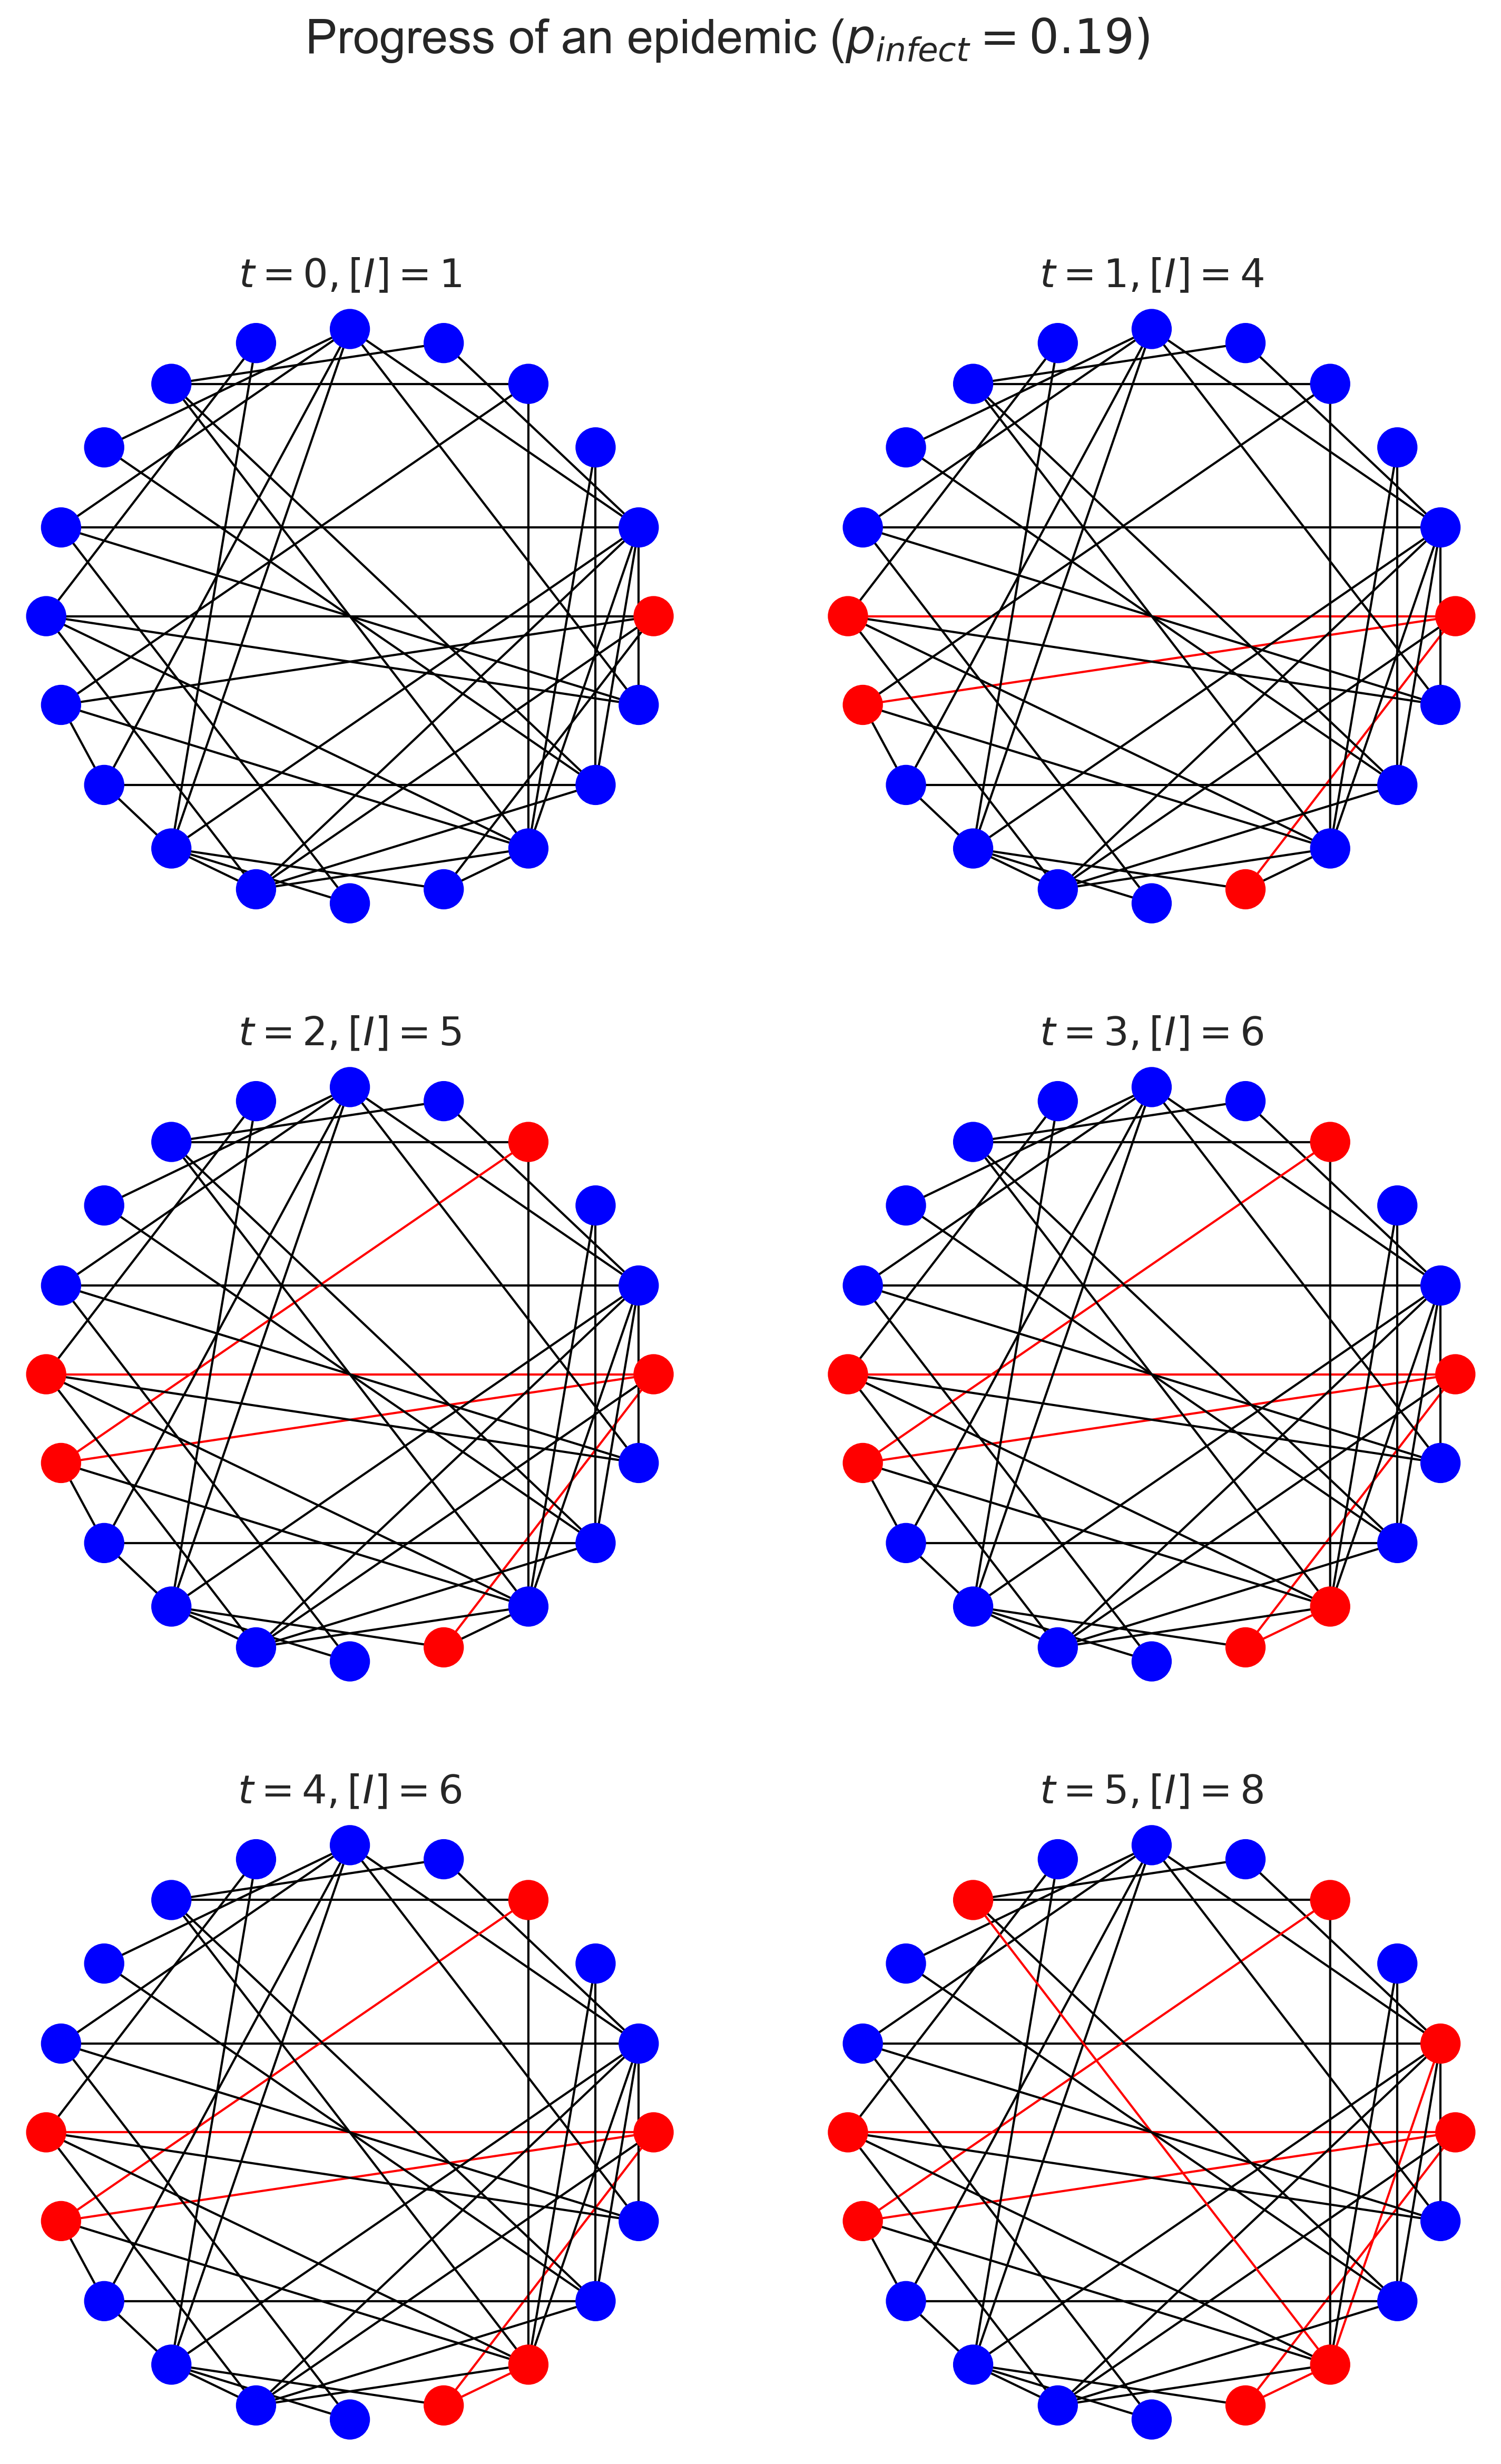

In [7]:
def drawEpidemic(g, ax, t):
    # compute node colours
    inf = 0
    nodes = list(g.nodes)
    ncs = [ 'blue' ] * len(nodes)
    for i in range(len(nodes)):
        n = nodes[i]
        if 'infected' in g.nodes[n].keys():
            ncs[i] = 'red'
            inf += 1
            
    # compute edge colours
    edges = list(g.edges)
    ecs = [ 'black' ] * len(edges)
    for i in range(len(edges)):
        (n, m) = edges[i]
        if 'occupied' in g.edges[n, m].keys():
            ecs[i] = 'red'

    # draw the contact tree
    networkx.draw_circular(g, ax=ax,
                           node_color=ncs, edge_color=ecs)
    ax.set_title('$t = {t}, [I] = {i}$'.format(t=t, i=inf))

(fig, axs) = plt.subplots(3, 2, figsize=(12, 18))

# build a small ER contact network
N = 20
pEdge = 0.25
g = networkx.gnp_random_graph(N, pEdge)

# infect a single person
g.nodes[0]['infected'] = True
infs = [ [ (None, [ 0 ]) ] ]

pInfect = 0.19

t = 0
for x in range(3):
    for y in range(2):
        # draw the infected nodes and tramission edges
        ax = axs[x][y]
        drawEpidemic(g, ax, t)
        
        # advance the epidemic
        infs.append(stepEpidemic(g))
        t += 1

# fine-tune the figure
plt.suptitle('Progress of an epidemic ($p_{\\mathit{infect}} = ' + '{i})$'.format(i=pInfect))        
plt.show()

There are several things to note here. Firstly, look how fast the number of infected (denoted $[I]$ in the figures) people increases! The disease rapidly goes from being somewhere to being *everywhere*, and just explodes as grows: the rate at which it spreads increases as the proportion of infected people increases, which is the essential characteristic of {index}`exponential growth`.

Secondly, notice how few edges were traversed. This makes sense, because there can only be one "transmission" edge for every node, which will only be a small fraction of the total nodes.

(sec:tracing-contact-trees)=
## Contact trees

We can make this clearer by drawing the process slightly differently. Instead of drawing the network as a whole and showing the way the infection spreads, we'll focus on the infected nodes only and show how they relate -- in other words, who affected whom.

We start at $t = 0$ with one infected node. At the next timestep we'll draw a second line of nodes that were infected by this node, connected to it by edges. In the next timestep we'll draw a third line of those who were infected by *those* nodes, and so on as time progresses.

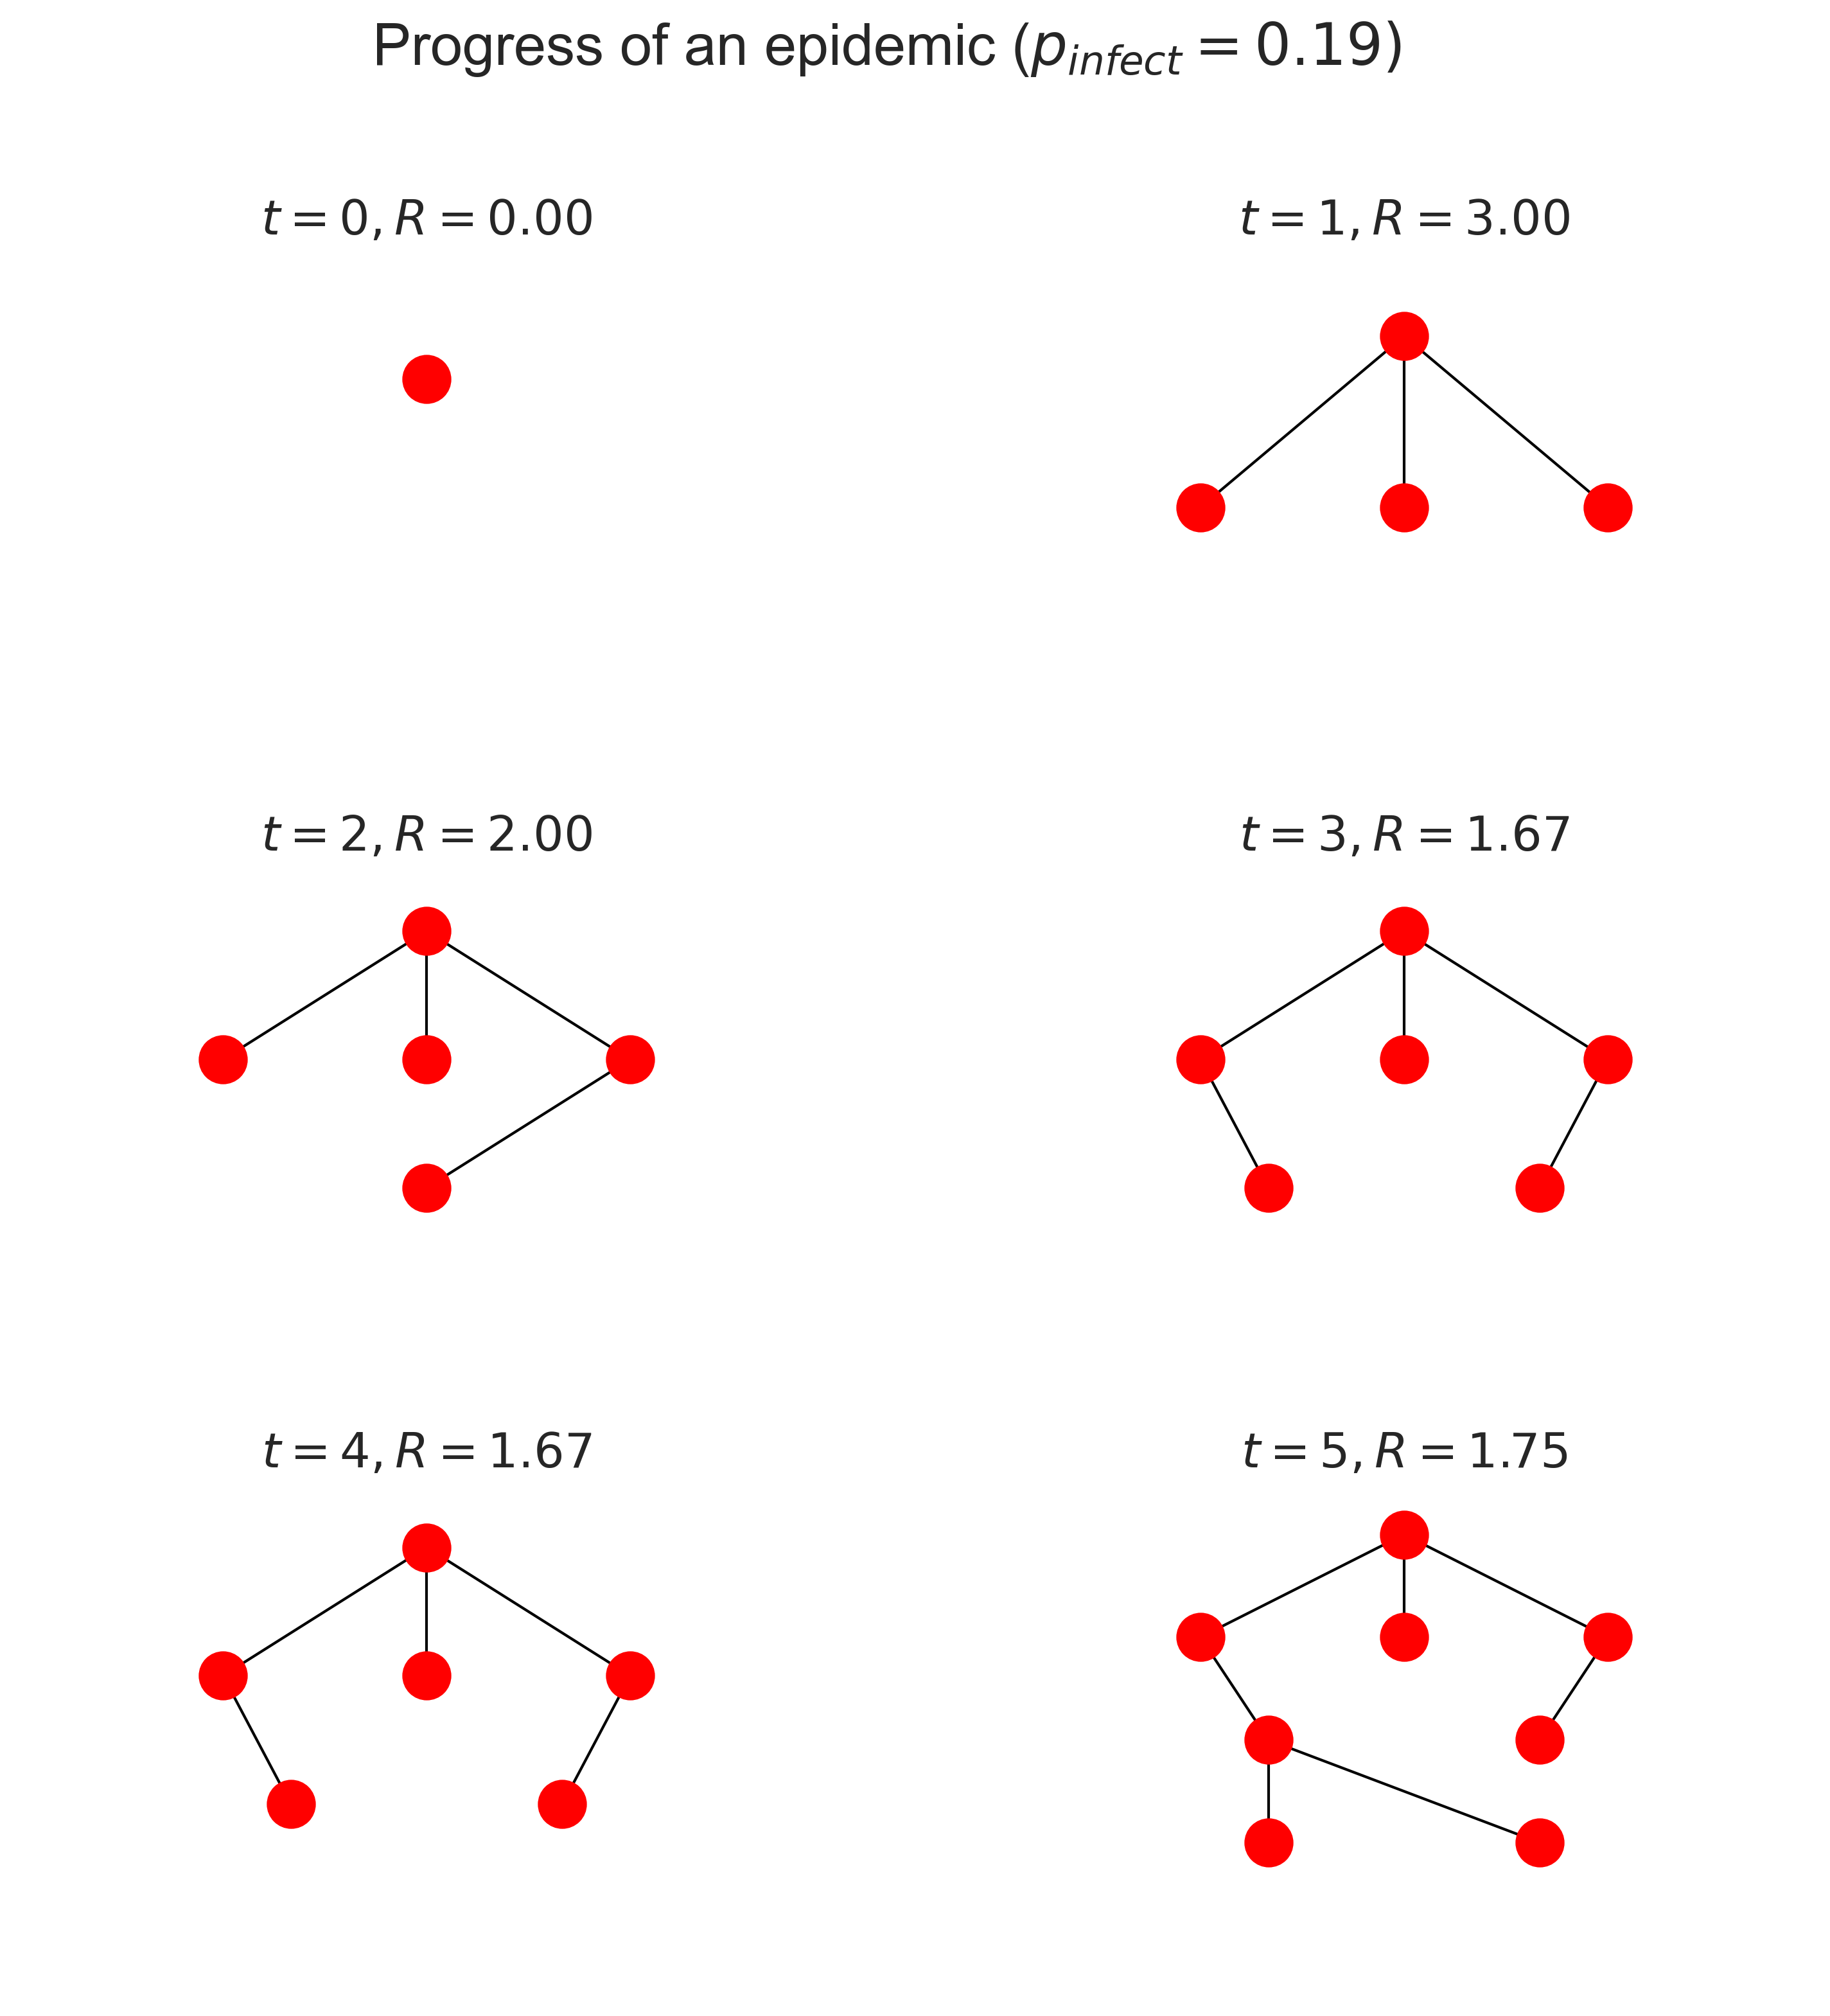

In [8]:
def drawContactTree(ax, t, ct):
    # turn the infection list into a network
    g = networkx.Graph()
    for infs in ct:
        for (n, ms) in infs:
            for m in ms:
                g.add_node(m)
                if n is not None:
                    g.add_edge(n, m)
                
    # compute the layers in the tree and the number of
    # infections from each individual
    secondaries = dict()
    ns = [ 0 ]
    layers = [ ns ]
    while len(ns) > 0:
        layer = []
        for n in ns:
            gs = set(g.neighbors(n))
            if len(layers) > 1:
                gs -= set(layers[-2])
            layer.append(list(gs))
            if len(gs) > 0:
                secondaries[n] = len(gs)
        ns = [n for cs in layer for n in cs]
        if len(ns) > 0:
            layers.append(ns)
    
    # compute locations
    pos = dict()
    dy = 1.0 / (len(layers) + 1)
    y = 1.0 - dy / 2
    for layer in layers:
        dx = 1.0 / (len(layer) + 1)
        x = dx
        for n in layer:
            pos[n] = (x, y)
            x += dx
        y -= dy
    
    # compute R_t
    if len(secondaries.keys()) > 0:
        Rt = sum(secondaries.values()) / len(secondaries.keys())
    else:
        Rt = 0
        
    # draw the tree
    networkx.draw_networkx(g, pos, ax=ax,
                           node_color='red', with_labels=False)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.axis('off')
    ax.set_title('$t = {t}, R = {rt:.2f}$'.format(t=t, rt=Rt))
    
(fig, axs) = plt.subplots(3, 2, figsize=(12, 12))

t = 0
for x in range(3):
    for y in range(2):
        ax = axs[x][y]
        layers = infs[:(t + 1)]
        drawContactTree(ax, t, layers)
        t += 1
        
# fine-tune the figure
plt.suptitle('Progress of an epidemic ($p_{\\mathit{infect}} = ' + '{i})$'.format(i=pInfect))        
plt.show()

This layered structure is a **{index}`contact tree`**. The topmost node is **{index}`patient zero`**, the first person infected in the epidemic. Those in the next layer down are the first set of secondary cases, the individuals infected by patient zero. And so on. Notice that because a node stays infected (in this very simple model) it may continue to infect nodes, so the layers can grow over time as more secondary cases occuir from each infected.
```{margin}
Computer scientists refer to the top-most node of a tree as the **root**, and always draw the root at the *top* of a tree diagram. Don't ask me why.
```

You'll notice that in the above diagram $\mathcal{R}$ goes *down* over time. Why is that? It's because each individual can only be infected once and, once infected, can't be infected again. Later infected individuals are therefore increasingly likely to have neighbours who are already infected, and so have less opportunity to pass on the disease to new people. This phenomenon of the network "filling up" with infected individuals &ndash; and later, in SIR, with those who've been removed &ndash; is why epidemics die out naturally without necessarily infecting the entire population. It's also the basis for vaccination, which is a topic we'll return to later.  

## Questions for discussion

- Suppose you're been put in charge of tracking and tracing people's contacts. How would you do it? Is there any technology that would make the job easier?
- Tracing contacts is quite invasive of people's privacy. Is it justified when there's an epidemic happening? How about in "normal" circumstances?